In [10]:
import xgboost
import shap
import matplotlib.pylab as pl
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
from sklearn.metrics import roc_auc_score, average_precision_score
import argparse
from sklearn.model_selection import GridSearchCV
import pickle
import sklearn
import scipy as sp
from scipy.cluster.hierarchy import complete, fcluster
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, linkage
matplotlib.rcParams['font.family'] = 'Times New Roman'

In [11]:
X = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/thesis.xlsx')
y = X['30_days_label']

drop_list = ['30_days_label']
X = X.drop(drop_list, axis=1)

fea_list = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/feature_list thesis.xlsx')
nominal_fea = fea_list[fea_list['Nominal']==1]['Type_Short_Name'].tolist()
nominal_fea = list(set(nominal_fea) & set(X.columns))
X = pd.get_dummies(X, columns=nominal_fea, drop_first=True)

display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/feature_list_Display_name thesis.xlsx')
display_col=[]
for col in X.columns:
    matching_display_names = display_name.loc[display_name['Type_Short_Name'] == col, 'Display_Name']
    if not matching_display_names.empty:
        display_col.append(matching_display_names.iloc[0])
    else:
        display_col.append(col)  # 일치하는 Display_Name이 없는 경우 원래의 컬럼 이름 사용
col_dict = dict(zip(X.columns, display_col))

print(X.columns)
print('After encoding', X.shape)

Index(['MIC: ETP', 'MIC: IMP or MPM', 'ICU days_before rectal swab (+)',
       'Admission day_before rectal swab (+)', 'Highest SBP', 'Highsest DBP',
       'Lowest SBP', 'Lowest DBP', 'Systolic BP at highest temperature',
       'Diastollic BP at highest temperature',
       ...
       'Dementia_1', 'Rectal spp._KPN_1', 'exposed_ colistin_1',
       'exposed_ aminoglycosides_1', 'MS: Disoriented_1', 'ANC >250_1',
       'Hemiplegia_1', 'abdominal invasive procedure _1', 'rectal tube_1',
       'Other blood pathogen_bacteria_1'],
      dtype='object', length=173)
After encoding (639, 173)


In [12]:
print(X.columns)
print(X.shape)
print('# samples: ', X.shape[0])
print('# positive samples: ', sum(y==1))
print('# negative samples: ', sum(y==0))
print('# features: ', X.shape[1])  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

y_train = np.array(y_train); y_test = np.array(y_test); y_val = np.array(y_val)

xlf = xgboost.XGBClassifier(learning_rate=0.05, n_estimators=200, objective='binary:logistic',
                                     gamma=0, max_depth=3, min_child_weight=1, colsample_bytree=0.7,
                                     colsample_bylevel=1, subsample=0.8, reg_lambda=1, reg_alpha=0,
                                     random_state=7, early_stopping_rounds=100,)
xlf.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose=False)
model_train = xlf
y_pre = model_train.predict_proba(X_test)[:, 1]

X_test = X_test.astype({col: int for col in X_test.select_dtypes(include=bool).columns})
X_train = X_train.astype({col: int for col in X_train.select_dtypes(include=bool).columns})

if len(X_train)>=5000:
    back_data = X_train.sample(n=5000, random_state=428)
else:
    back_data = X_train
if len(X_test)>=2000:
    fore_data = X_test.sample(n=2000, random_state=528)
    fore_data_label = pd.DataFrame(y_test).sample(n=20, random_state=528)
else:
    fore_data = X_test
    fore_data_label = pd.DataFrame(y_test)

explainer = shap.TreeExplainer(model_train, data=back_data)
shap_values = explainer.shap_values(fore_data)

Index(['MIC: ETP', 'MIC: IMP or MPM', 'ICU days_before rectal swab (+)',
       'Admission day_before rectal swab (+)', 'Highest SBP', 'Highsest DBP',
       'Lowest SBP', 'Lowest DBP', 'Systolic BP at highest temperature',
       'Diastollic BP at highest temperature',
       ...
       'Dementia_1', 'Rectal spp._KPN_1', 'exposed_ colistin_1',
       'exposed_ aminoglycosides_1', 'MS: Disoriented_1', 'ANC >250_1',
       'Hemiplegia_1', 'abdominal invasive procedure _1', 'rectal tube_1',
       'Other blood pathogen_bacteria_1'],
      dtype='object', length=173)
(639, 173)
# samples:  639
# positive samples:  72
# negative samples:  567
# features:  173


In [13]:
clustering = shap.utils.hclust(X_train, y_train, random_state=7)

 36%|███████████████                           | 62/173 [00:13<00:18,  5.94it/s]No/low signal found from feature 61 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 62 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 63 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 64 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 65 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from featu

 75%|██████████████████████████████▊          | 130/173 [00:21<00:08,  4.95it/s]No/low signal found from feature 129 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 130 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 77%|███████████████████████████████▌         | 133/173 [00:22<00:05,  7.28it/s]No/low signal found from feature 132 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 133 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 79%|████████████████████████████████▏        | 136/173 [00:22<00:04,  8.72it/s]No/low signal found from feature 135 (this i

174it [00:25,  4.87it/s]                                                        


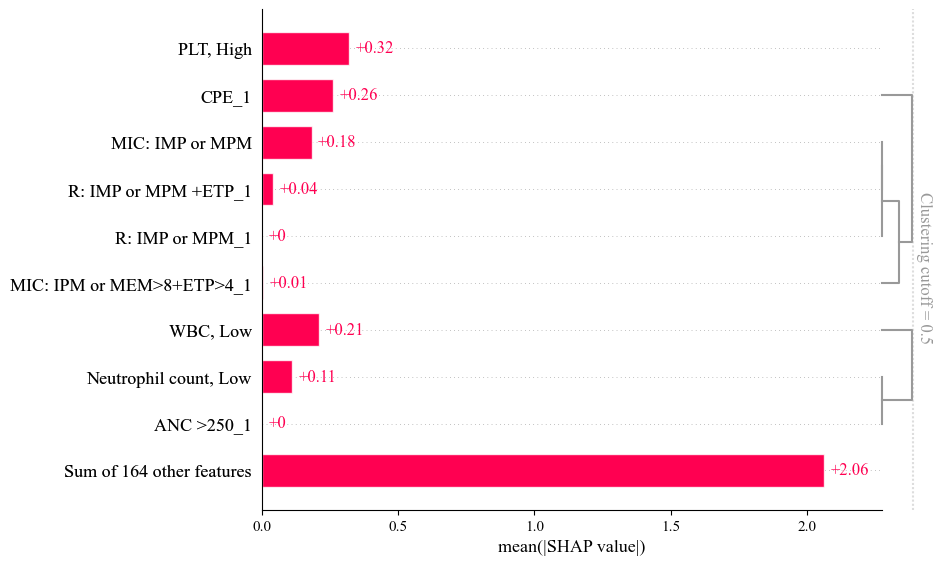

In [6]:
explainer = shap.TreeExplainer(model_train, data=back_data)
shap_values = explainer(fore_data)  # This should give you an Explanation object if your SHAP version supports it
clustering = shap.utils.hclust(X_train, y_train, random_state=7)
shap.plots.bar(shap_values, clustering=clustering)

In [4]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# 계층적 클러스터링 수행
linkage_matrix = sch.linkage(X_train, method='ward')

# Dendrogram 그리기
plt.figure(figsize=(10, 7))
dendro = sch.dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()


NameError: name 'X_train' is not defined

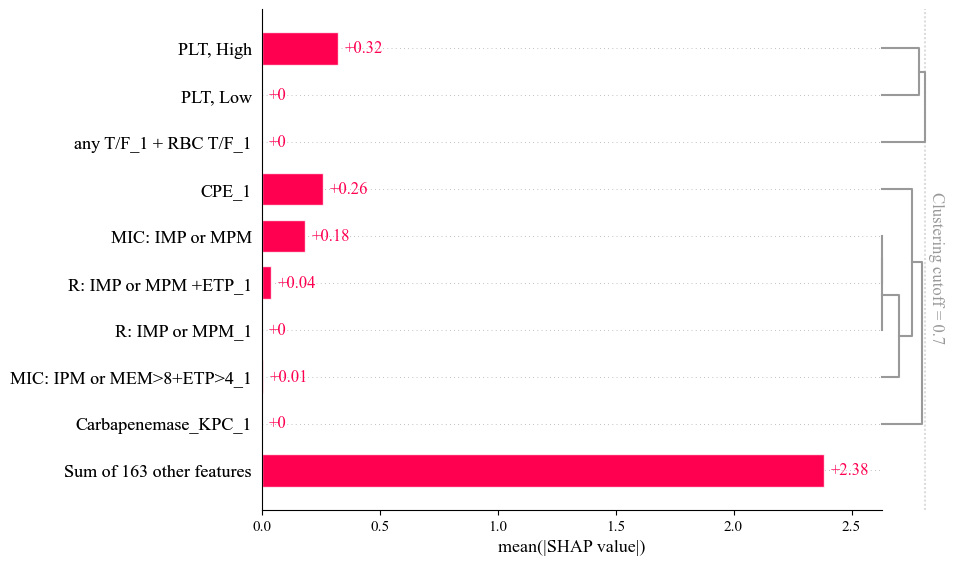

<Figure size 640x480 with 0 Axes>

In [23]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.7)
pl.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/thesis/clustercutoff.tiff', format='tiff', dpi=300)
pl.show()

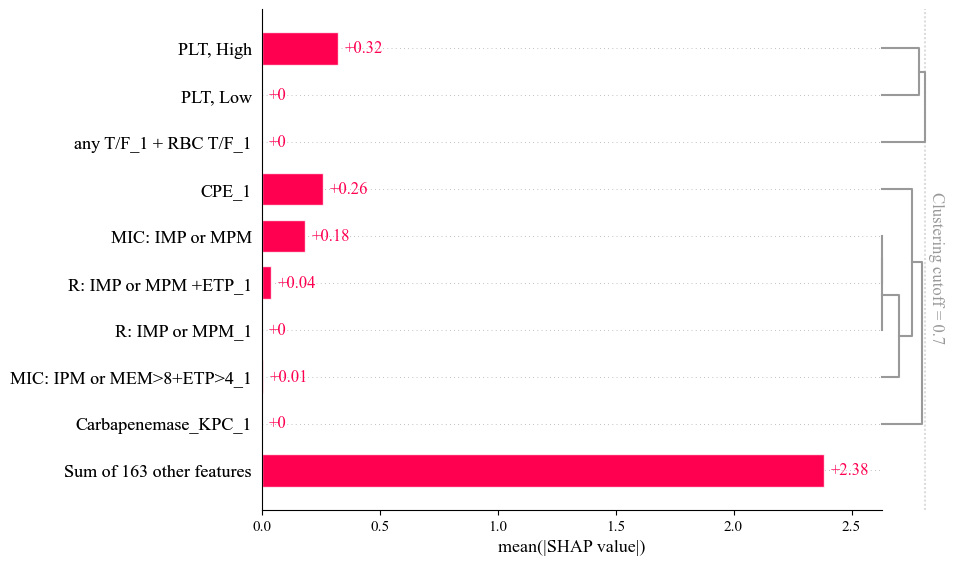

<Figure size 640x480 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt

# SHAP 값을 시각화합니다. 이 부분에서는 시각화 코드가 바로 이어집니다.
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.7)

# 시각화 직후, TIFF 파일로 저장합니다. 경로와 파일 이름을 확인해 주세요.
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/thesis/clustercutoff.tiff', format='tiff', dpi=300)

# 시각화를 화면에 표시합니다.
plt.show()


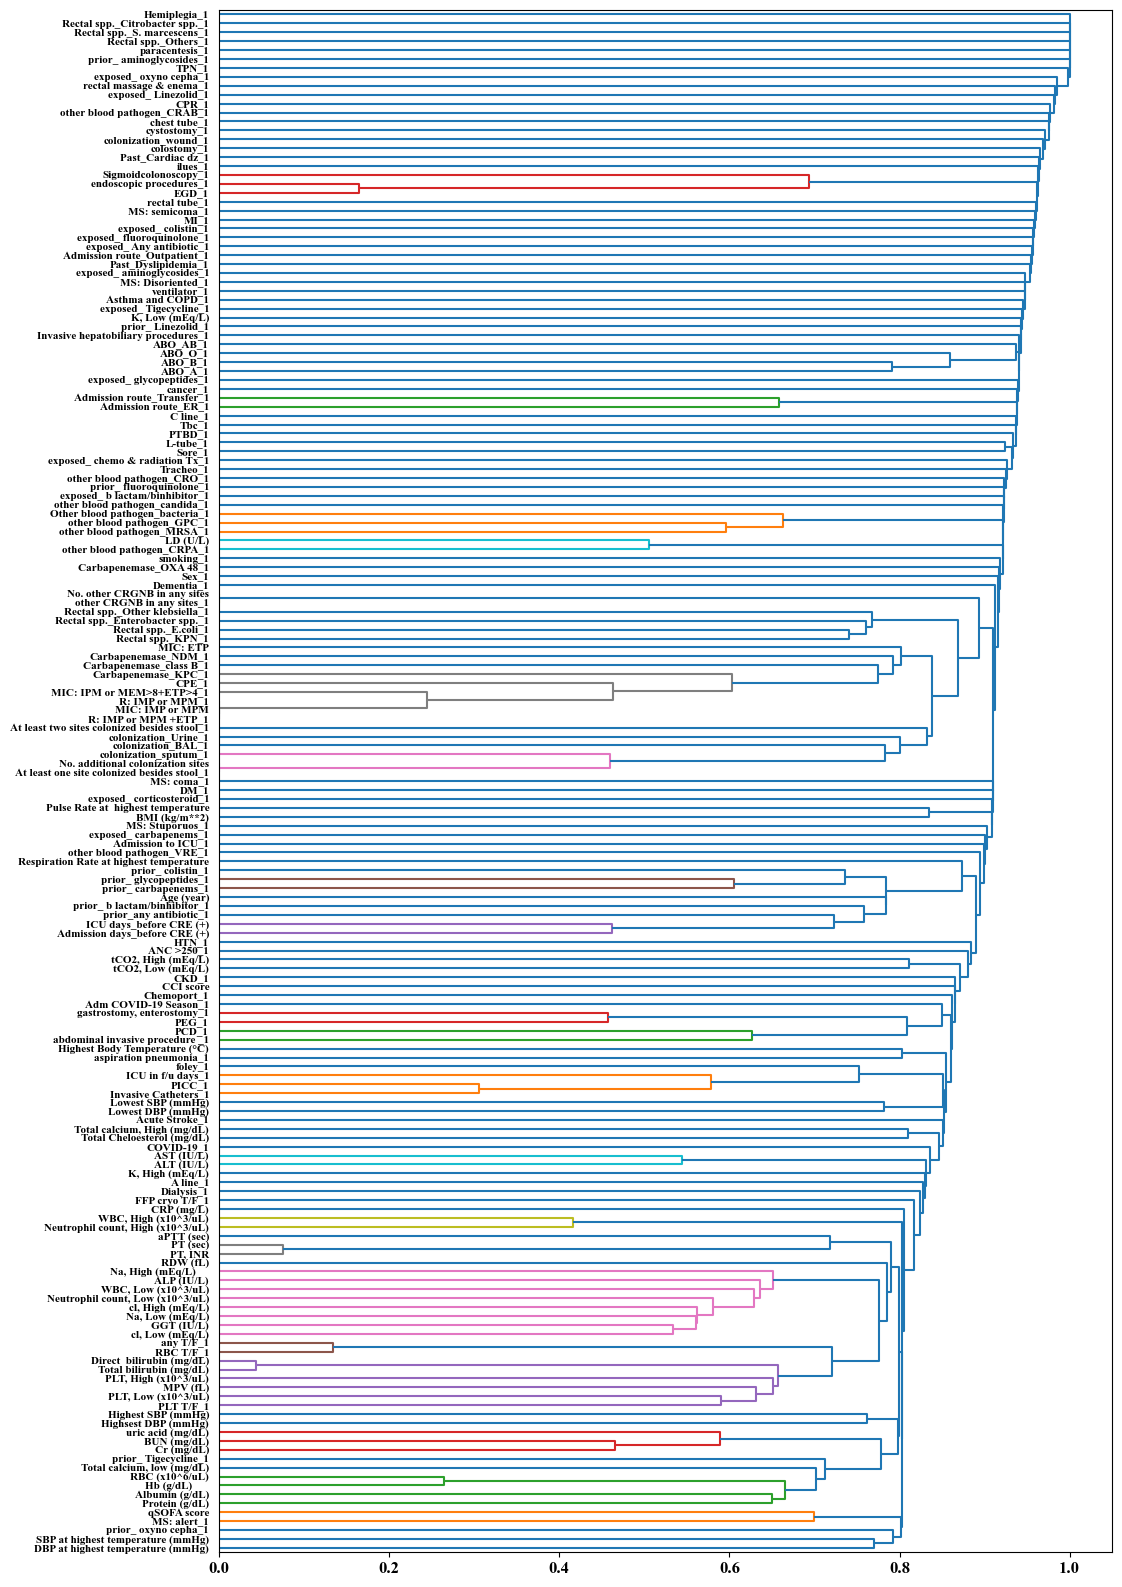

In [21]:
plt.rcParams['font.weight'] = 'bold'  # 모든 텍스트 요소에 대해 굵은 글씨 적용
plt.rcParams['axes.labelweight'] = 'bold'  # 축 라벨에 대해 굵은 글씨 적용
# 특성 이름을 라벨로 사용
col_dict = dict(zip(X.columns, display_col))

# 글씨 크기 설정
pl.rcParams['font.size'] = 11 # 또는 필요한 크기로 조정
pl.rcParams['axes.labelsize'] = 12
pl.rcParams['xtick.labelsize'] = 12
pl.rcParams['ytick.labelsize'] = 11

pl.figure(figsize=(13, 16))
dendrogram(clustering, labels=list(col_dict.values()), orientation='right', distance_sort='descending', show_leaf_counts=True, leaf_font_size=8)  # leaf_font_size 추가
# Adjust layout to prevent cutting off labels
plt.tight_layout()
plt.subplots_adjust(left=0.3)  # Adjust the left margin as needed
pl.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/cluster.tiff', format='tiff', dpi=300)
pl.show()

In [16]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86837 sha256=3d32448ae53b38c1a250a1787f5c54f60cfe2f13bf098ee40bd3bb5c182a96d1
  Stored in directory: /Users/kj/Library/Caches/pip/wheels/de/07/2e/814a6ee82e37528f2044a609a431028375b149bc31f03c0e27
Successfully built umap-learn


In [23]:
from umap.umap_ import UMAP

# compute 2D embedding of raw variable values
X_2d = UMAP(
  n_components=2, n_neighbors=200, min_dist=0
).fit_transform(X_train)

# Assuming you have SHAP values calculated and stored in `shap_values`
# compute 2D embedding of SHAP values
s_2d = UMAP(
  n_components=2, n_neighbors=200, min_dist=0
).fit_transform(shap_values.values[:, :, 1])


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [26]:
from umap.umap_ import UMAP

# Compute 2D embedding of raw variable values, ensuring n_neighbors is not too large
X_2d = UMAP(
  n_components=2, 
  n_neighbors=min(200, len(X_train) - 1),  # Ensure n_neighbors is less than the number of samples
  min_dist=0
).fit_transform(X_train)

# Compute 2D embedding of SHAP values, ensuring n_neighbors is not too large
s_2d = UMAP(
  n_components=2, 
  n_neighbors=min(200, shap_values.shape[0] - 1),  # Ensure n_neighbors is less than the number of samples in shap_values
  min_dist=0
).fit_transform(shap_values)


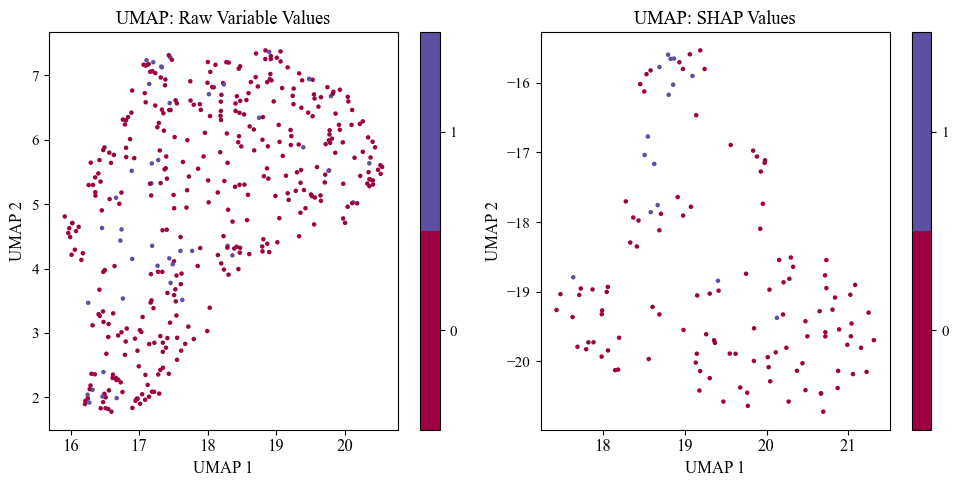

In [27]:
import matplotlib.pyplot as plt

# Plot UMAP embedding of raw variable values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(len(np.unique(y_train))+1)-0.5).set_ticks(np.arange(len(np.unique(y_train))))
plt.title('UMAP: Raw Variable Values')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Assuming 'y_test' is available and corresponds to 'shap_values'
# Plot UMAP embedding of SHAP values
plt.subplot(1, 2, 2)
plt.scatter(s_2d[:, 0], s_2d[:, 1], c=y_test[:len(s_2d)], cmap='Spectral', s=5)  # Adjust as per your y vector for SHAP
plt.colorbar(boundaries=np.arange(len(np.unique(y_test))+1)-0.5).set_ticks(np.arange(len(np.unique(y_test))))
plt.title('UMAP: SHAP Values')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()


In [32]:
from sklearn.cluster import DBSCAN

# Identify clusters using DBSCAN
s_labels = DBSCAN(eps=1.5, min_samples=20).fit(s_2d).labels_

In [34]:
!pip install skope-rules

In [35]:
import numpy as np
from skrules import SkopeRules

# Assuming you have some data to work with (X_train, y_train)
# You might need to replace this with your actual data loading code
# X_train, y_train = ...

skope_rules_clf = SkopeRules(feature_names=np.array(['feature1', 'feature2', 'feature3']), max_depth_duplication=2, n_estimators=30, precision_min=0.3, recall_min=0.1)
skope_rules_clf.fit(X_train, y_train)

# Print the rules
print(skope_rules_clf.rules_)


ImportError: cannot import name 'Iterable' from 'collections' (/Users/kj/anaconda3/lib/python3.11/collections/__init__.py)

In [36]:
import numpy as np
from skrules import SkopeRules

for cluster in np.unique(s_labels):
    # create target variable for individual cluster
    yc = (s_labels == cluster) * 1
    # use SkopeRules to identify rules with a maximum of two comparison terms
    sr = SkopeRules(max_depth=2).fit(X, yc)
    # print best decision rule
    print(cluster, sr.rules_[0][0])
    # print precision and recall of best decision rule
    print(f"Precision: {sr.rules_[0][1][0]:.2f}",
          f"Recall   : {sr.rules_[0][1][1]:.2f}\n")

ImportError: cannot import name 'Iterable' from 'collections' (/Users/kj/anaconda3/lib/python3.11/collections/__init__.py)